In [324]:
# Import relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

In [325]:
# Read in data from titanic.csv
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head() # Check using head if data is read correctly

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [326]:
# Print a concise info on the titanic_df
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [327]:
# You can also drop whichever other columns you'd like here
titanic_df.drop("Cabin", axis=1, inplace=True)

### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column

In [328]:
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

Machine Learning classifiers don't know how to handle strings. As a result, you need to convert it into a categorical representation. There are two main ways to go about this:

Label Encoding: Assigning, for example, 0 for "male" and 1 for "female". The problem here is it intrinsically makes one category "larger than" the other category.

One-hot encoding: Assigning, for example, [1, 0] for "male" and [0, 1] for female. In this case, you have an array of size (n_categories,) and you represent a 1 in the correct index, and 0 elsewhere. In Pandas, this would show as extra columns. For example, rather than having a "Sex" column, it would be a "Sex_male" and "Sex_female" column. Then, if the person is male, it would simply show as a 1 in the "Sex_male" column and a 0 in the "Sex_female" column.

There is a nice and easy method that does this in pandas: get_dummies()

In [329]:
titanic_df = pd.get_dummies(titanic_df, prefix="Sex", columns=["Sex"])
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,True,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,True,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,True,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,False,True


Now, we do the same to the "Embarked" column.

In [330]:
titanic_df = pd.get_dummies(titanic_df, prefix="Embarked", columns=["Embarked"])
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,False,True,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,True,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,True,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,True,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,False,True,False,False,True


Create a Decision Tree that can predict the survival of passengers on the Titanic. Make sure not to impose any restrictions on the depth of the tree.
Select relevant variables from the data and split the data into a training, development, and test set

In [331]:
# Identify the independent variable as X and dependent variables as y which is 'Survived'.
selected_features = ['Pclass','Sex_female','Sex_male','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']
X = titanic_df[selected_features]
y = titanic_df['Survived']

# Split the data into training, test  and development data
r=42
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y,test_size=0.25,random_state=r)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, test_size=0.25,random_state=r)


Train a decision tree and make a plot of it. Compute your model’s accuracy on the development set.

Performance without pruning: 0.7623318385650224
At depth: 16
Accuracy on the development set: 0.83


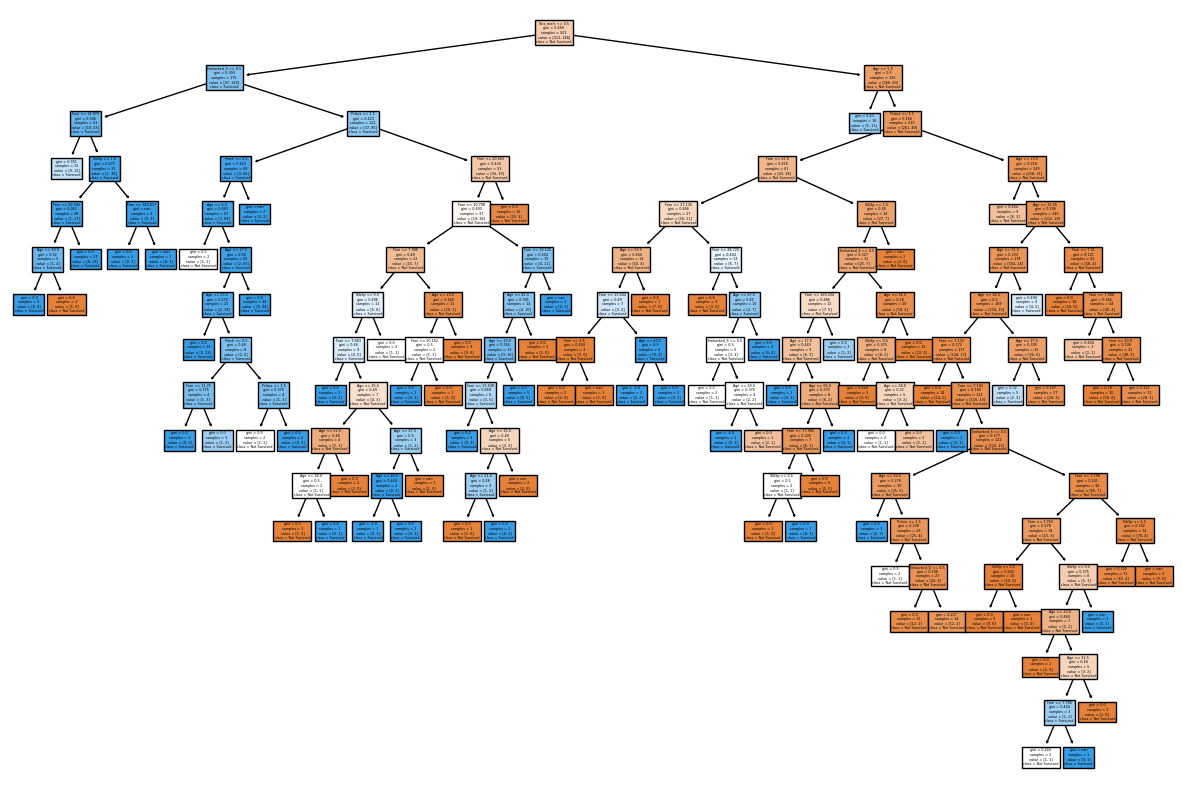

In [332]:
# Training a model without pruning
dt_classifier = DecisionTreeClassifier(max_depth=None, random_state=r)
dt_classifier.fit(X_train, y_train)
print("Performance without pruning:", dt_classifier.score(X_test, y_test))
print("At depth:", dt_classifier.tree_.max_depth)

# Compute model's accuracy on the development set
y_dev_pred = dt_classifier.predict(X_dev)
accuracy = accuracy_score(y_dev, y_dev_pred)
print(f"Accuracy on the development set: {accuracy:.2f}")

# Plot the decision tree
feature_names = list(X.columns)
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, filled=True, feature_names=feature_names, class_names=['Not Survived', 'Survived'])
plt.show()

Try building your model with different values of the max_depth [2-10]. At each step, create a plot of your tree and store the accuracies on both the training and development data

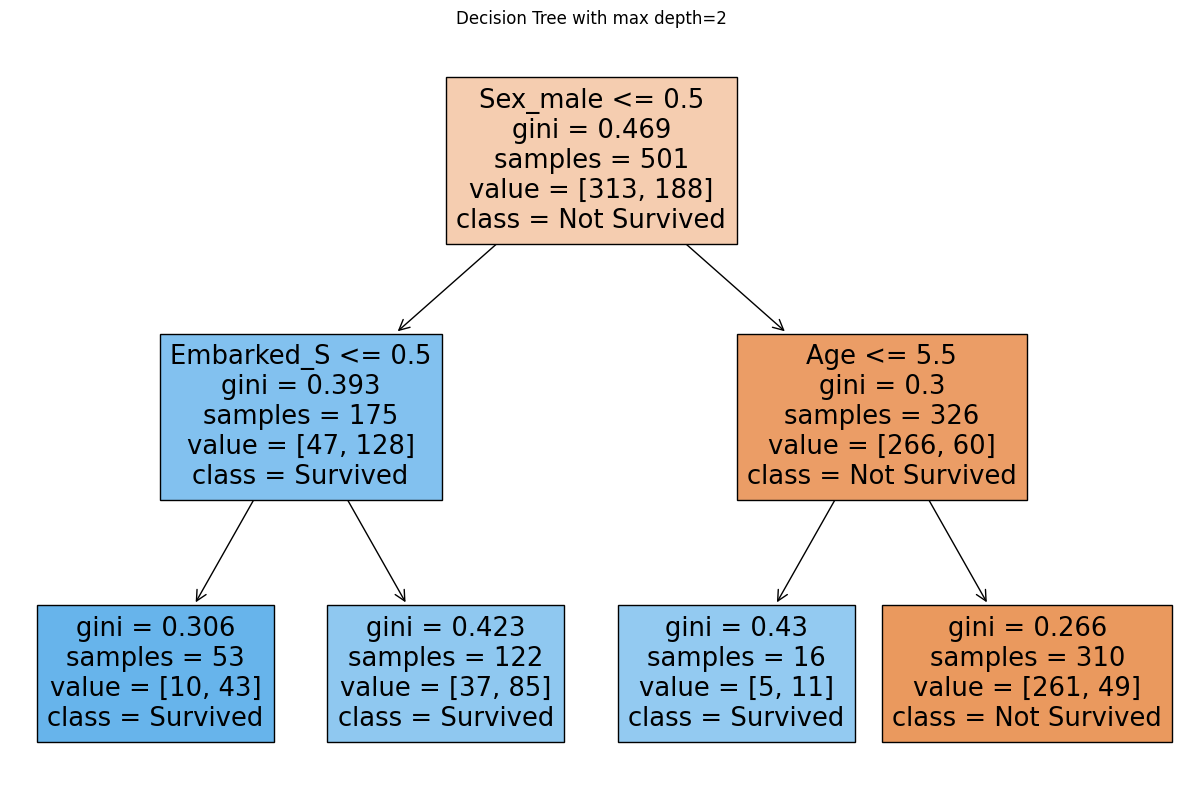

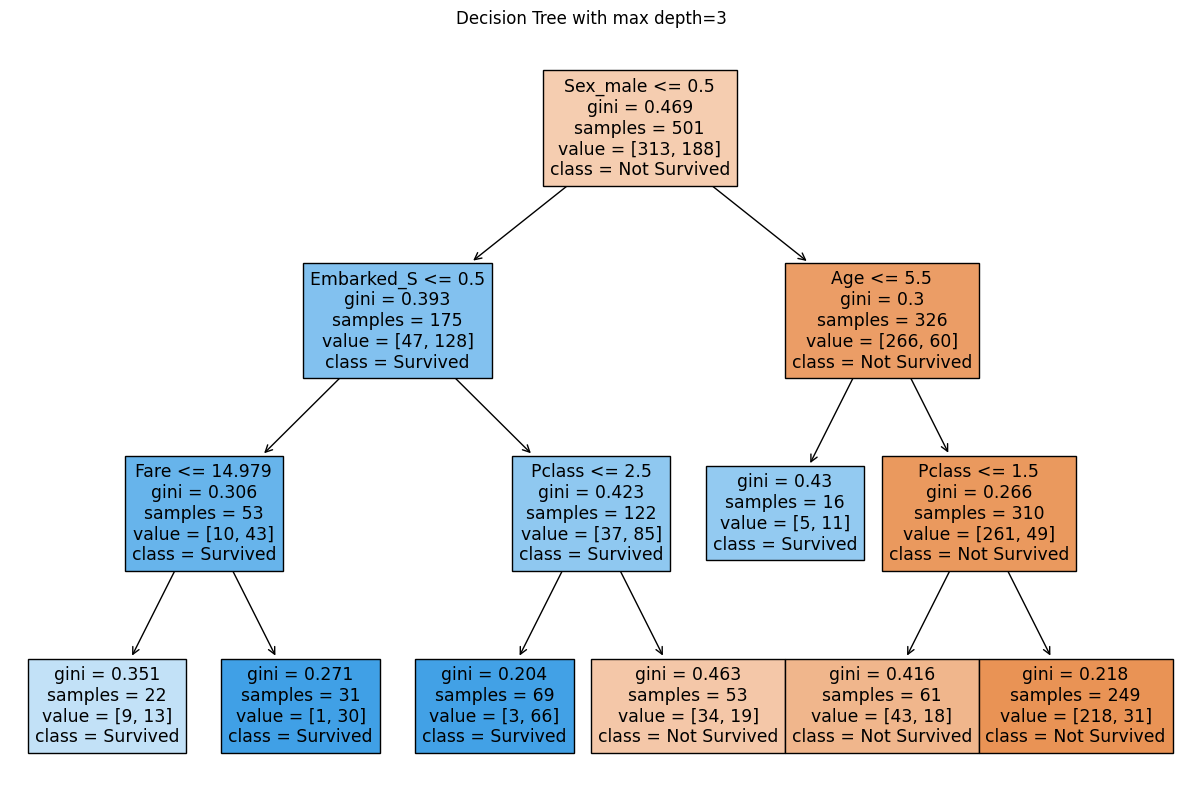

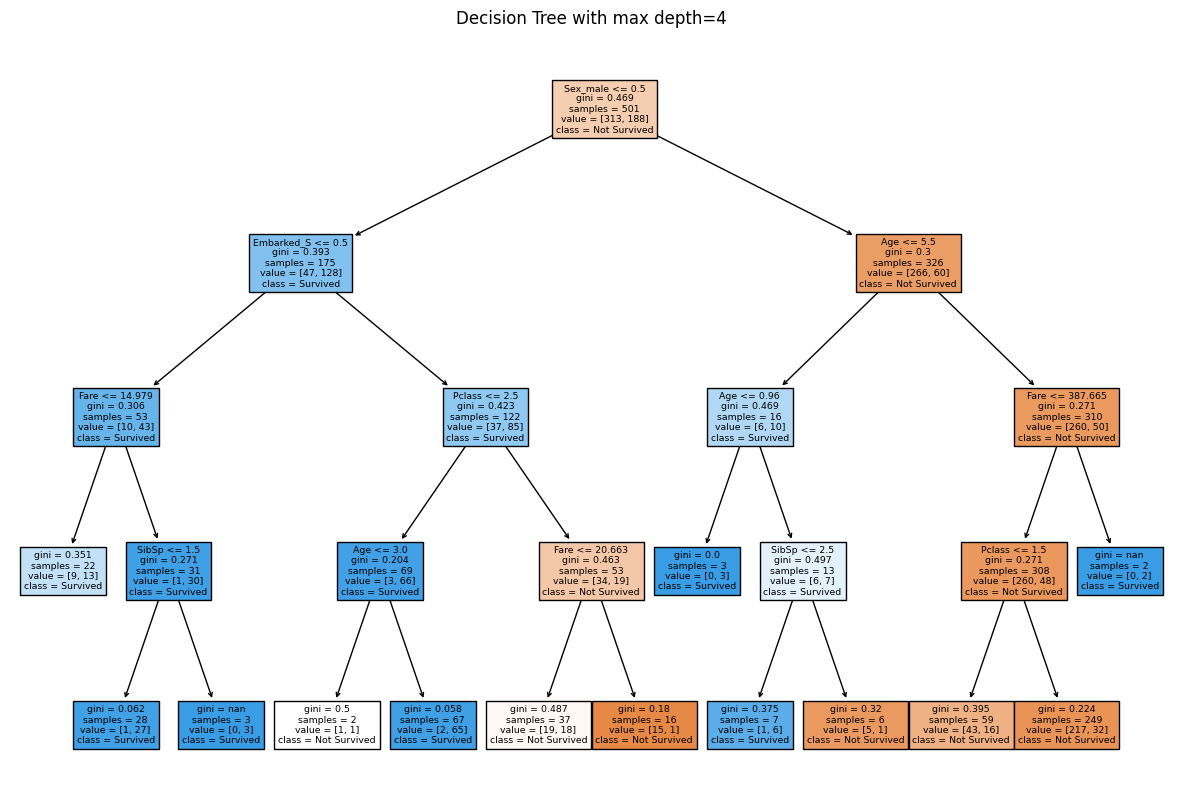

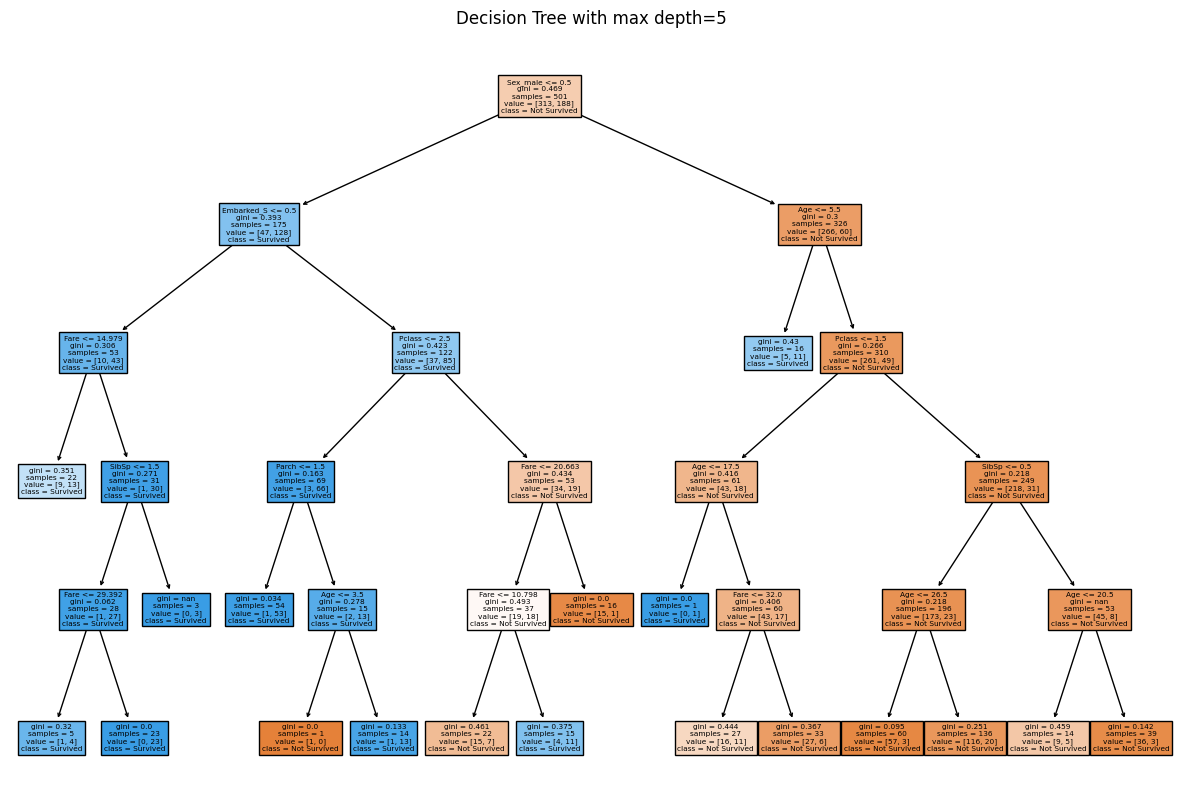

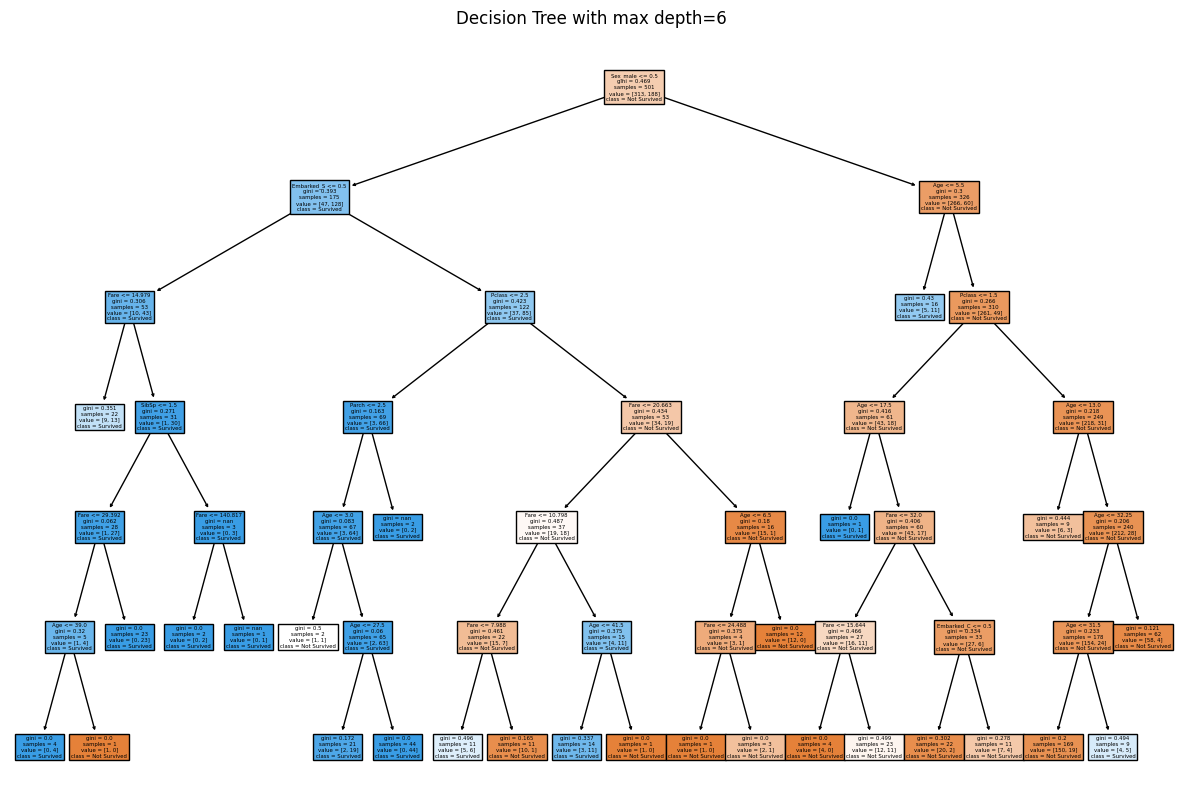

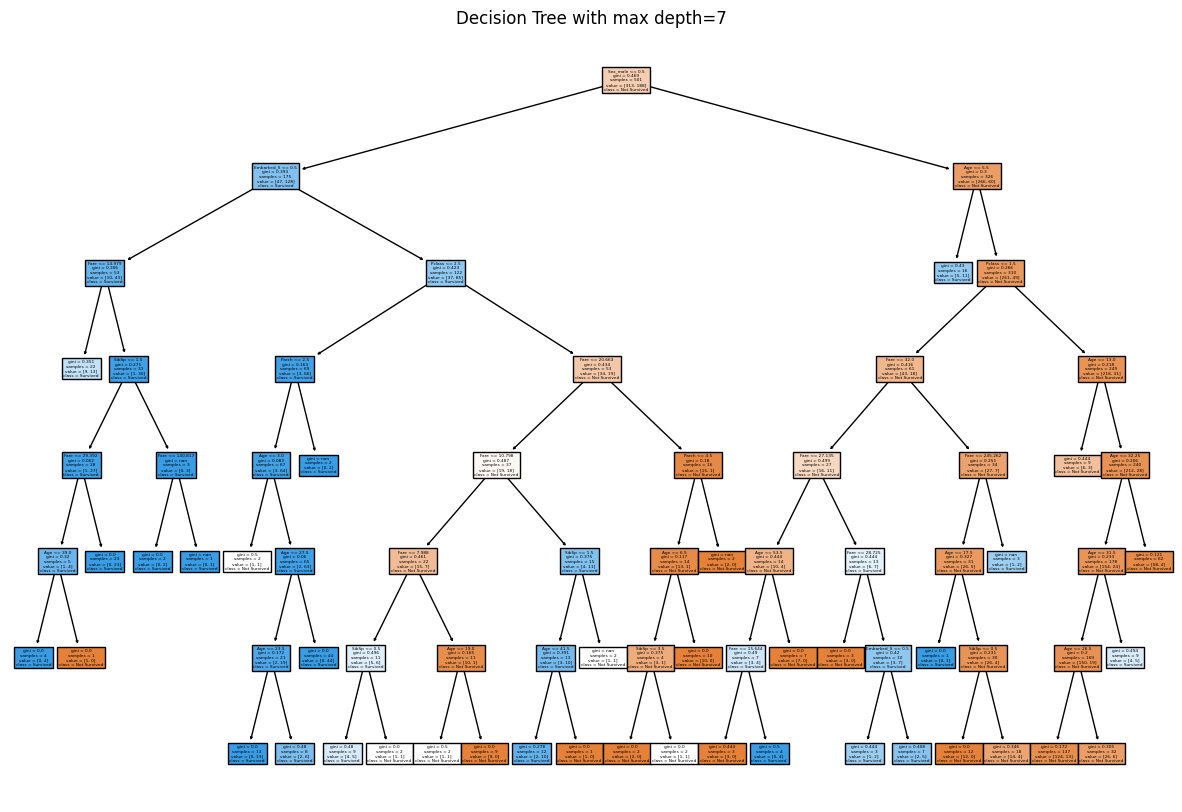

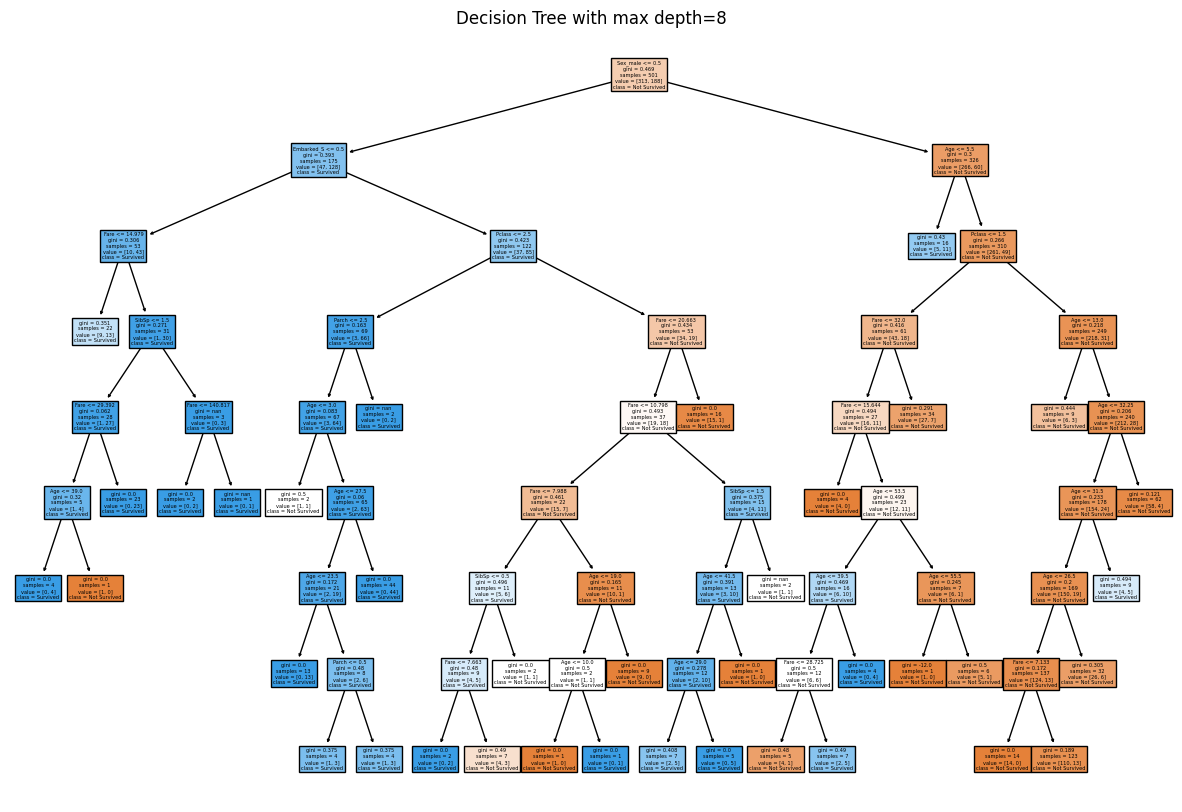

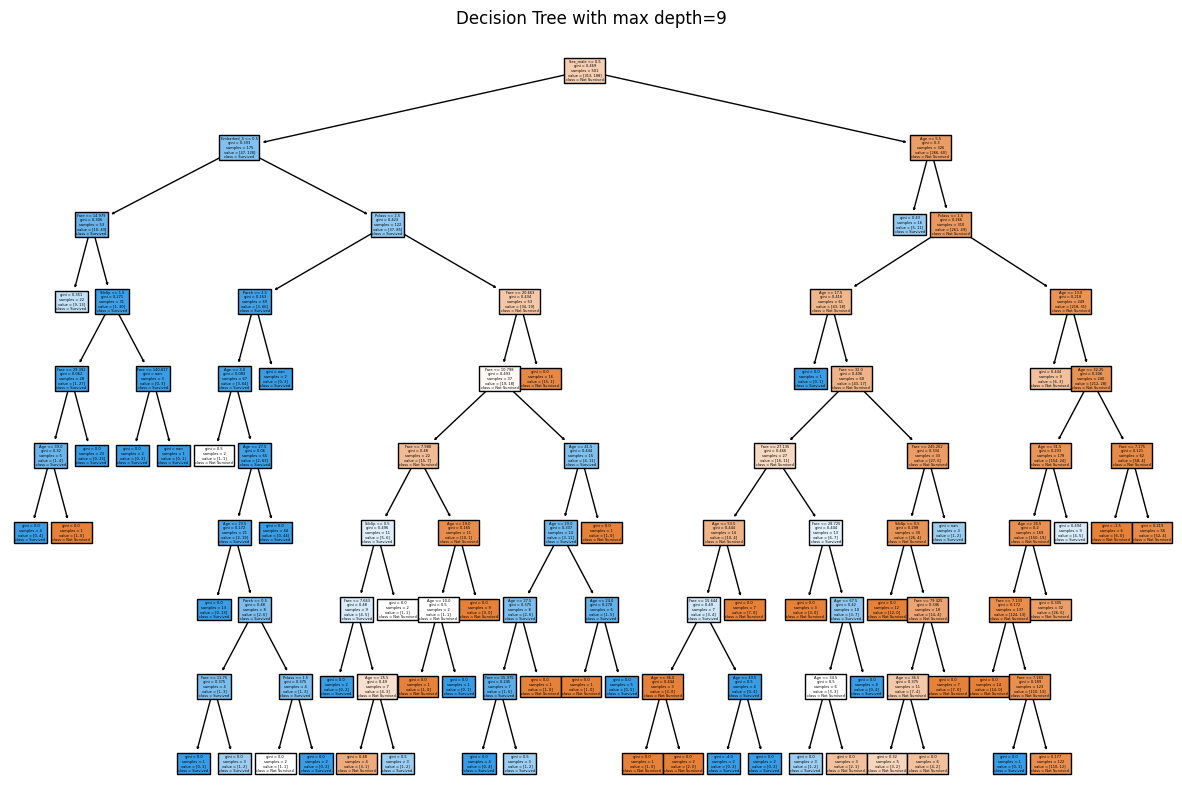

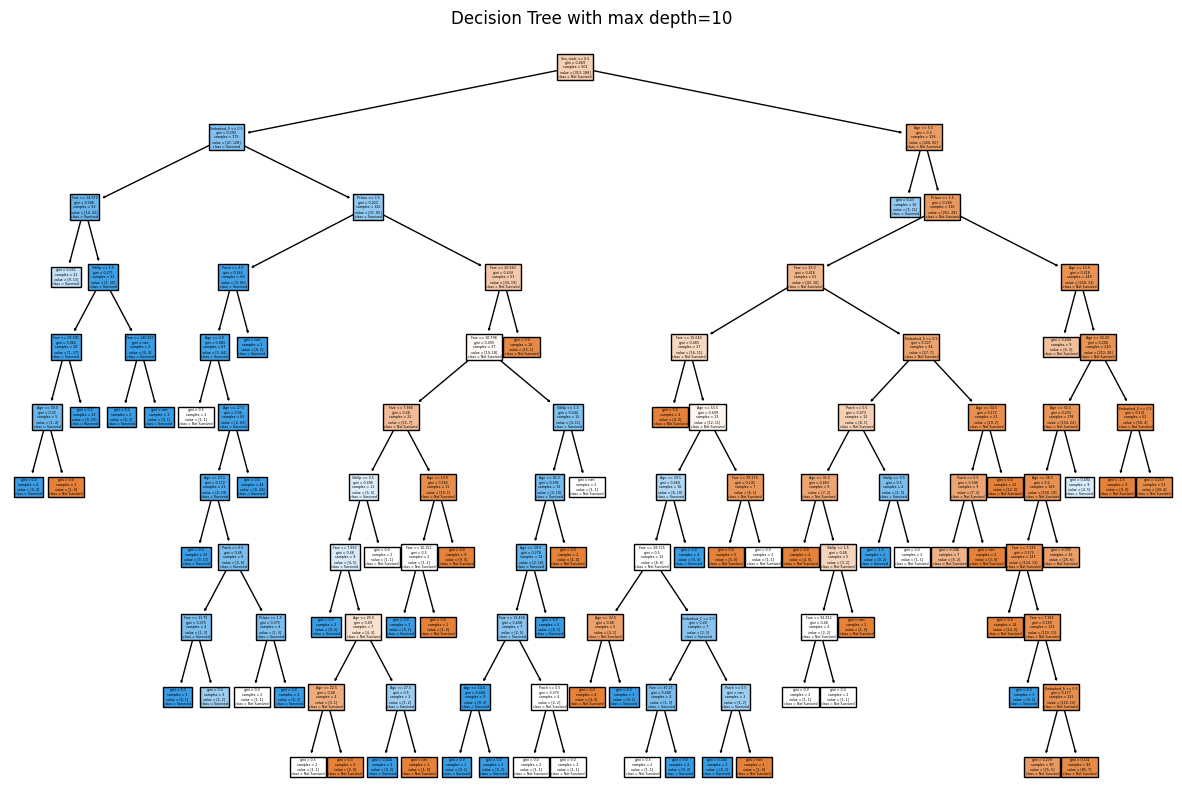

In [333]:
# Define a range of max_depth values from 2 to 10
max_depth_values = range(2, 11)

# Lists to store accuracies
train_accuracies = []
dev_accuracies = []

# Loop over different values of max_depth
for max_depth in max_depth_values:

    # Train a decision tree
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth,random_state=r)
    dt_classifier.fit(X_train, y_train)

    # Compute accuracies on training and development data
    train_accuracy = dt_classifier.score(X_train, y_train)
    dev_accuracy = dt_classifier.score(X_dev, y_dev)

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    dev_accuracies.append(dev_accuracy)

    # Plot the decision tree
    plt.figure(figsize=(15,10))
    plot_tree(dt_classifier, filled=True, feature_names=feature_names, class_names=['Not Survived', 'Survived'])
    plt.title(f'Decision Tree with max depth={max_depth}')
    plt.show()

Plot a line of your training accuracies and another of your development accuracies in the same graph. 

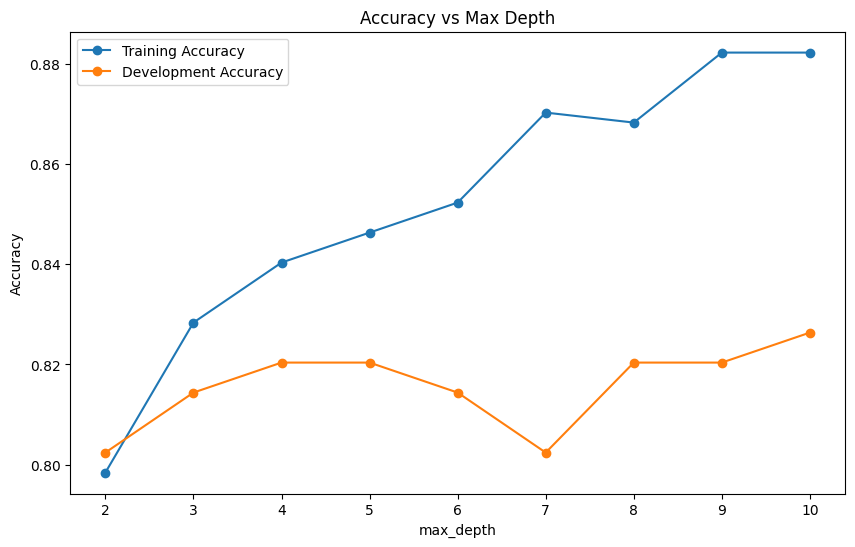

In [334]:
# Plot training and development accuracies over different max_depth
plt.figure(figsize=(10,6))
plt.plot(max_depth_values, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depth_values,dev_accuracies, label='Development Accuracy',marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()


Write down what shape the lines have and what this shape means.

Good Fit/Robust: With the training data in terms of accuracy we can see the accuracy is around 0.78 when max_depth is around 2 and as max_depth increases we can see the accuracy also increases gradually and reaches accuracy of more than 0.89 when max_depth is 10. The line exhibits an upward trend, indicating the model is fitting the training data better as it becomes more complex(increase in max_depth).  
Overfitted: With the development data in terms of accuracy we can see the accuracy is around 0.81 when max_depth is around 2 peaks when max_depth is 4 with an accuracy of around 0.841 approx and we can see it fluctuates here and decreases when max_depth values starts to become higher. The development accuracy increases initially reaches a peak and then decreases and this repeats again as max_depth is increased. This kind of pattern is more likely to be leaning towards overfitting. The model initially shows ability to fit correctly but loses its ability to be accurate on new unseen data and accuracy declines. There is an optimal value for max_depth where model performs its best on the development set.

Report the accuracy of your final model on the test data.

In [335]:
# Obtain test accuracy for test data
test_accuracy = dt_classifier.score(X_test, y_test)
print(f"Accuracy of test data set: {test_accuracy:2f}")

Accuracy of test data set: 0.780269


L3T03 coding starts from below here. The above is L3T02 related tasks.

Create a Bagged, Random Forest, and Boosted tree for the titanic dataset in the same way that you created a regular Classification Tree.

In [336]:
# Split dataset into train 70% and test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define max_depth, n_estimators, r to be used in all models
max_depth_value = 10
n_estimators_value = 100
r = 7

# Create base model using Decision Tree model
base = DecisionTreeClassifier(max_depth=max_depth_value)
base.fit(X_train, y_train)

# Calculate accuracy_score for base model 
base_score = base.score(X_test, y_test)

# Create a Bagged Decision Tree Model
bagged = BaggingClassifier(estimator=base,
                                       n_estimators=n_estimators_value, random_state=r)
bagged.fit(X_train, y_train)

# Calculate accuracy_score for Bagged Decision Tree Model
bagged_score = bagged.score(X_test, y_test)

In [337]:
# Check for missing values in X_train before fitting a Random Forest Model, as Random Forest does not handle 
# missing values (NaN) in features. 
# Missing columns with NaN values must be addressed before training the model.

missing_columns = X_train.columns[X_train.isnull().any()]
print("Columns with missing values:", missing_columns)

Columns with missing values: Index(['Age'], dtype='object')


In [338]:
# Drop rows with missing values in column 'Age' using dropna. The 'Age' column, which was identified as having 
# missing NaN values, is then updated. 
X_train.dropna(subset=['Age'], inplace=True)

# Update corresponding labels
y_train = y_train.loc[X_train.index] 

# Apply the same to the test set
X_test.dropna(subset=['Age'], inplace=True)

# Update corresponding labels
y_test = y_test.loc[X_test.index]

# Create a Random Forest Classifier Model
forest = RandomForestClassifier(n_estimators= n_estimators_value, max_depth= max_depth_value, random_state=r)
forest.fit(X_train, y_train)

# Calculate the accuracy score for the Random Forest Classifier Model
forest_score = forest.score(X_test,y_test)

# Get feature importances
feature_imp = pd.Series(forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Random Forest Feature Importances")
print(feature_imp)

Random Forest Feature Importances
Age           0.233141
Fare          0.209540
Sex_female    0.175445
Sex_male      0.151570
Pclass        0.097662
SibSp         0.055788
Parch         0.043954
Embarked_S    0.015494
Embarked_C    0.014001
Embarked_Q    0.003405
dtype: float64


In [339]:
# Impute missing values for the 'Age' column using the mean strategy 
# Instantiate the imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform on the training data
X_train['Age'] = imputer.fit_transform(X_train[['Age']])

# Apply the same imputer to the test data
X_test['Age'] = imputer.transform(X_test[['Age']])

# Create a Random Forest Classifier model using the imputed data
forest = RandomForestClassifier(n_estimators=n_estimators_value, max_depth=max_depth_value, random_state=r)
forest.fit(X_train, y_train)

# Calculate the accuracy score for Random Forest Tree Classifier model
forest_score = forest.score(X_test,y_test)

# Get feature importances
feature_imp = pd.Series(forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Display feature importances
print("Random Forest Feature Importances:")
print(feature_imp)

Random Forest Feature Importances:
Age           0.233141
Fare          0.209540
Sex_female    0.175445
Sex_male      0.151570
Pclass        0.097662
SibSp         0.055788
Parch         0.043954
Embarked_S    0.015494
Embarked_C    0.014001
Embarked_Q    0.003405
dtype: float64


In [340]:
# Create the Boosted Tree Classifier model
boosted = GradientBoostingClassifier(n_estimators=n_estimators_value, max_depth=max_depth_value, random_state=r)
boosted.fit(X_train, y_train)

# Calculate the accuracy score using the test set and accuracy_score method
boosted_predictions = boosted.predict(X_test)
boosted_score = accuracy_score(y_test, boosted_predictions)

# Get Feature importances
feature_imp_boosted = pd.Series(boosted.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp_boosted

Age           0.282999
Sex_male      0.263081
Fare          0.210008
Pclass        0.112446
SibSp         0.057212
Sex_female    0.042802
Embarked_S    0.014991
Parch         0.008695
Embarked_C    0.006613
Embarked_Q    0.001154
dtype: float64

From the Random Forest model, determine which of the features is the one that contributes the most to predicting whether a passenger survives or not.  
From the output above for Random Forest Model (using either impute or dropna for removing rows with NaN values) we can see that feature 'Age' contributes the most to predicting whether a passenger survives or not. The importance values represent the proportion of importance each feature has in making predictions. In this case 'Age' has the highest importance, followed closely by 'Fare' and then 'Sex_female'


Pick one of these methods, and tune the parameters n_estimators and max_depth.

In [341]:
# Define the parameter grid for defining various estimators and max_depth parameters
parameter_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}

# Create the Random Forest classifier
forest = RandomForestClassifier(random_state=r)

# Create GridSearchCV object
grid_search = GridSearchCV(forest, parameter_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters")
print(best_params)

# Use the best model to make predictions
best_forest = grid_search.best_estimator_

# Evaluate the best model on the test set and calculate the accuracy score
test_accuracy_best = best_forest.score(X_test, y_test)
print(f"Accuracy of the best Random Forest model on the test set: {test_accuracy_best:.2f}")

Best Parameters
{'max_depth': 10, 'n_estimators': 50}
Accuracy of the best Random Forest model on the test set: 0.81


Report the accuracy of all models and report which model performed the best, including the values for n_estimators and max_depth that the best model had.

In [342]:
# Print n_estimators and max_depth which is used across all the models
print("n_estimators: ", n_estimators_value)
print("max_depth: ", max_depth)

# Accuracy score method for Decision Tree Classifier which is Base Model
print("Accuracy for Base model:",base_score)

# Accuracy score for Bagged Decision Tree Model
print("Accuracy for Bagged Classifier Model using Score method:",bagged_score)

# Accuracy score for Random Forest Model
print("Accuracy for Random Forest Classifier Model using Score method: ", forest_score)

# Accuracy score for Boosted Tree Model
print("Accuracy for Boosted Tree Model using Accuracy Score method: ", boosted_score)


n_estimators:  100
max_depth:  10
Accuracy for Base model: 0.7574626865671642
Accuracy for Bagged Classifier Model using Score method: 0.8208955223880597
Accuracy for Random Forest Classifier Model using Score method:  0.8046511627906977
Accuracy for Boosted Tree Model using Accuracy Score method:  0.772093023255814


From the accuracy scores above across various models we can see the highest score was obtained by Bagged Classifier Model and this is the best fit model for this scenario and dataset.